# Overview

this notebook runs the models and save the time and score
the saved dataframe can be found in `../data/processed/results_{date}`

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")
from src.graph import NetworkGraph

In [3]:
import time
import gurobi
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [4]:
from src.flows import *
from src.models.DQL.DQL import run

In [5]:
from flatland.envs.rail_env import RailEnv
from flatland.envs.observations import *
from flatland.envs.rail_generators import complex_rail_generator,rail_from_manual_specifications_generator,random_rail_generator, RailGenerator
from flatland.envs.schedule_generators import complex_schedule_generator, random_schedule_generator, ScheduleGenerator
from flatland.utils.rendertools import RenderTool

### Helper functions

In [6]:
def create_env(height,width,seed,number_of_agents=4):
    env = RailEnv(width=width,
              height=height,
              rail_generator=complex_rail_generator(nr_start_goal=20, nr_extra=1, 
                                                    min_dist=6, max_dist=99999, seed = seed),
              schedule_generator=complex_schedule_generator(),
              number_of_agents=number_of_agents)
    
    
    
    return env

In [7]:
def run_flow(env,height,width):
    
    #extract the transition matrix
    matrix_rail = np.array(env.rail.grid.tolist())
    
    #build the transition network
    flatlandNetwork = NetworkGraph(matrix_rail)

    #get the sources and sinks of the different agents
    sources = []
    sinks = []
    for agent in env.agents:
        sources.append(agent.initial_position)
        sinks.append(agent.target)
        
    #build the time exanded network and connect the sources and sinks
    TestNetworkTime = TimeNetwork(flatlandNetwork, depth=max(2*(height+width),40))
    TestNetworkTime.connect_sources_and_sink(sources,sinks)
    
    
    #get the Integral Program formulation of the problem and solve it 
    print(sources,sinks)
    mcflow = MCFlow(TestNetworkTime.graph,len(sources),TestNetworkTime.topology)
    mcflow.solve()
    
    #extract the path and compute the scores (total time spent by the agent in the grid)
    cost= 0
    if not mcflow.check_if_feasible():
        return "Infeasible"
    print(mcflow.m.objVal)
    paths = mcflow.extract_paths()
    for agent,path in paths.items():
        print(path)
        cost += -1+len(path)/2
       
    return cost

In [8]:
def run_flow_rl(env,width,height,seed,n_start_goal=20,initial_value = 0,
             learning_rate = 0.8,gamma = 0.9,epsilon = 0.1,threshold = 0.3):
    number_agents = len(env.agents)
    n_episodes = width*height*number_agents*15
    n_steps = 2*(width+height)
    print(seed)
    cost, n_episodes, total_time = run(number_agents,
                                    width,height,
                                    n_start_goal,
                                    seed,
                                    n_episodes,
                                    n_steps,
                                    initial_value,
                                    learning_rate,
                                    gamma,
                                    epsilon,
                                    threshold)
    
    return cost, n_episodes, total_time

In [9]:
def run_experiment_and_save_results(method, results,agents = 4, repetition = 5, 
                                    pathToSavedGrids = None, grids_size = None):
    nodes = []
    edges = []
    sizes_list = []
    if pathToSavedGrids is None:
        for sizes in tqdm(grids_size):
            for i in range(repetition):
                seed = sizes[0]*sizes[1]+i
                print(f'seed {seed}')
                env = create_env(sizes[0],sizes[1],seed,number_of_agents=agents)
                
                env.step({0:2})
                env_renderer = RenderTool(env,agent_render_variant=3)
                env_renderer.render_env(show=True, show_predictions=False, show_observations=False)
                env = create_env(sizes[0],sizes[1],seed,number_of_agents=agents)
    
                start = time.time()
                cost = run_flow(env,sizes[0],sizes[1])
                print(cost)
                sizes_list.append(sizes[0]*sizes[1])                    
                time_spent = time.time()-start
                results = results.append({'Size of the grid' : sizes[0]*sizes[1] , 
                                          'Score' : cost, "Time":time_spent, 
                                          "Type":"CO","Number of episodes": None} , 
                                         ignore_index=True)
                results.to_csv("../data/processed/results_comparison"+str(agents)+".csv")
                start = time.time()
                cost, n_episodes, total_time = run_flow_rl(env,sizes[1],sizes[0],seed)
                print(cost)
                sizes_list.append(sizes[0]*sizes[1])                    
                time_spent = time.time()-start
                results = results.append({'Size of the grid' : sizes[0]*sizes[1] , 
                                          'Score' : cost, "Time":time_spent, "Number of episodes": n_episodes,
                                          "Type":"RL"} , 
                                         ignore_index=True)
                results.to_csv("../data/processed/results_comparison.csv")
                print("---")
                
                env_renderer.close_window()
                
    else:
        raise NotImplementedError("Load the map and proceed to inference")

### Constant definition

In [10]:
grids_size = [(10,5),(10,10),(15,10),(15,15),(20,15),(20,20),(25,20),
              (25,25),(25,30),(30,30),(35,30), (35,35),(40,35),(40,40),
              (45,40),(45,45),(50,50),(55,50),(55,55),(60,55),(60,60),
              (65,60),(65,65),(70,65),(70,70),(75,70),(75,75),(80,75),
             (80,80),(85,90),(90,90),(95,90),(95,95),(100,95),(100,100)]

In [11]:
results = pd.DataFrame()

## Actual run

In [13]:
run_experiment_and_save_results(run_flow, results, agents = 4, repetition=1, grids_size=grids_size[:4])

  0%|          | 0/4 [00:00<?, ?it/s]

seed 50
[(1, 2), (6, 3), (0, 4), (9, 3)] [(9, 0), (0, 0), (7, 0), (2, 0)]
Optimize a model with 48564 rows, 52432 columns and 196656 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 46694 rows and 49006 columns
Presolve time: 0.07s
Presolved: 1870 rows, 3426 columns, 7394 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.564e+03
 Factor NZ  : 3.615e+04 (roughly 2 MBytes of memory)
 Factor Ops : 1.007e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.40632471e+04 -5.95402040e+04  5.60e+02 1.00e+00  2.69e+02     0s
   1   1.38916817e+04 -5.93385022e+04  1.41e+02 2.13e-14  7.07e+01     0s
   2   2.82992059e+03 -3.899708

 25%|██▌       | 1/4 [17:45<53:17, 1065.85s/it]

57
---
seed 100
[(1, 0), (0, 2), (3, 2), (9, 0)] [(8, 4), (9, 9), (5, 8), (0, 5)]
Optimize a model with 95732 rows, 102992 columns and 386736 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 94299 rows and 100154 columns
Presolve time: 0.10s
Presolved: 1433 rows, 2838 columns, 5875 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.265e+03
 Factor NZ  : 2.424e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.799e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.77186365e+04 -5.50698102e+04  4.77e+02 6.94e+00  2.48e+02     0s
   1   9.47368202e+03 -5.15800237e+04  1.16e+02 2.13e-14  6.37e+01     0s
   2   1.85494901e+03

 50%|█████     | 2/4 [1:30:17<1:08:23, 2051.71s/it]

87
---
seed 150
[(4, 9), (8, 3), (11, 9), (1, 6)] [(0, 2), (13, 8), (3, 7), (11, 0)]
Optimize a model with 168660 rows, 181536 columns and 681808 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 165646 rows and 175449 columns
Presolve time: 0.20s
Presolved: 3014 rows, 6087 columns, 12527 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.858e+03
 Factor NZ  : 5.811e+04 (roughly 4 MBytes of memory)
 Factor Ops : 1.426e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   9.80500808e+04 -1.47675413e+05  7.97e+02 8.86e+00  3.48e+02     0s
   1   2.89027472e+04 -1.39330332e+05  2.31e+02 2.49e-14  1.04e+02     0s
   2   6.793813

 75%|███████▌  | 3/4 [7:28:34<2:11:25, 7885.14s/it]

94
---
seed 225
[(3, 0), (12, 9), (2, 12), (14, 5)] [(2, 14), (4, 8), (12, 5), (6, 6)]
Optimize a model with 338924 rows, 366640 columns and 1378320 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 330964 rows and 350962 columns
Presolve time: 0.39s
Presolved: 7960 rows, 15678 columns, 33095 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.935e+04
 Factor NZ  : 2.253e+05 (roughly 11 MBytes of memory)
 Factor Ops : 1.402e+07 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.79046966e+05 -4.64721530e+05  8.55e+02 1.35e+01  4.85e+02     0s
   1   8.33591342e+04 -4.52780056e+05  2.53e+02 3.55e-14  1.48e+02     0s
   2   2.2

KeyboardInterrupt: 

# PLOTS

In [35]:
df = pd.read_csv("../data/processed/results_comparison4.csv", index_col = 'Unnamed: 0')

In [36]:
df

,Number of episodes,Score,Size of the grid,Time,Type
0,NaN,39.0,50.0,4.032870,CO
1,-1.0,57.0,50.0,1060.226460,RL
2,NaN,48.5,100.0,8.529773,CO
3,-1.0,87.0,100.0,4341.882924,RL
4,NaN,46.0,150.0,15.813664,CO
5,-1.0,94.0,150.0,21478.898641,RL
6,NaN,49.0,225.0,34.568511,CO


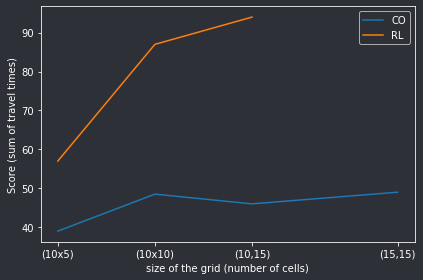

In [37]:
plt.rcParams['savefig.facecolor'] = (46/255., 48/255., 55/255.)
plt.rcParams['axes.facecolor'] = (46/255., 48/255., 55/255.)
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.spines['bottom'].set_color("white")
ax.spines['top'].set_color("white") 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.title.set_color('white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
fig.set_facecolor((46/255., 48/255., 55/255.))
ax.set_facecolor((46/255., 48/255., 55/255.))


plt.plot(df[df.Type == 'CO']['Size of the grid'],df[df.Type == 'CO'].Score,label = "CO")
plt.plot(df[df.Type == 'RL']['Size of the grid'],df[df.Type == 'RL'].Score, label = "RL")

plt.xlabel("size of the grid (number of cells)")

x1 = [50,100,150,225]
squad = ['(10x5)','(10x10)','(10,15)','(15,15)']

ax.set_xticks(x1)
ax.set_xticklabels(squad)

plt.ylabel("Score (sum of travel times)")

l = plt.legend()
for text in l.get_texts():
    text.set_color("white")



ax = plt.gca()
plt.tight_layout()
plt.savefig("../data/processed/comparison.png", dpi = 300)

In [ ]:
df_20_agents = pd.read_csv("../data/processed/results_20_agents.csv",index_col = 'Unnamed: 0')

In [ ]:
df_10_agents = pd.read_csv("../data/processed/results_10_agents.csv",index_col = 'Unnamed: 0')

In [ ]:
df_4_agents = pd.read_csv("../data/processed/results_4_agents.csv",index_col = 'Unnamed: 0')

In [ ]:
plt.rcParams['savefig.facecolor'] = (46/255., 48/255., 55/255.)
plt.rcParams['axes.facecolor'] = (46/255., 48/255., 55/255.)
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.spines['bottom'].set_color("white")
ax.spines['top'].set_color("white") 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.title.set_color('white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
fig.set_facecolor((46/255., 48/255., 55/255.))
ax.set_facecolor((46/255., 48/255., 55/255.))


plt.scatter(df_4_agents['Size of the grid'],df_4_agents['Time'].values/60, label = "4 trains",alpha= 0.8)
plt.scatter(df_10_agents['Size of the grid'],df_10_agents['Time'].values/60, label = "10 trains",alpha = 0.8)
plt.scatter(df_20_agents['Size of the grid'],df_20_agents['Time'].values/60, label = "20 trains",alpha = 0.8)


plt.xlabel("size of the grid (number of cells)")

x1 = [20**2,40**2,50*50,60*60]
squad = ['(20x20)','(40x40)','(50,50)','(60x60)']

ax.set_xticks(x1)
ax.set_xticklabels(squad)

plt.ylabel("time until solution (min)")
#plt.title("Experiment of multicommodity flow formulation until memory error (model > 40 Gb)")

l = plt.legend()
for text in l.get_texts():
    text.set_color("white")



ax = plt.gca()
plt.tight_layout()
plt.savefig("../data/processed/time.png", dpi = 300)